In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install -q pytrends
from pytrends.request import TrendReq

Credits to [github.com/joweich](https://github.com/joweich/year-in-search-trends/blob/main/yearinsearchtrends.py) for the base code that I adapted to create this!

In [104]:
def get_interest_over_time(
    keywords: list,
    timeframe: str,
    chunksize: int = 1,
    cat: int = 0,
    geo: str = "",
    normalize: bool = True,
) -> pd.DataFrame:
    """Requests weekly search trend data for a list of keywords and writes results into a dataframe.
    Args:
        keywords (list): List of search keywords.
        timeframe (str): Requested timeframe in the format 'yyyy-mm-dd yyyy-mm-dd'.
        chunksize (int, optional): Group request into junks to gracefully call the API.
            Must be <= 5. Defaults to 1.
        cat (int, optional): Search category according to
            https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories. Defaults to 0.
        geo (str, optional): Geocode to localize search trends.
            See https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes for codes. Defaults to "".
        normalize (bool, optional): Whether to normalize individual keywords in the same chunk.
            If False, the trends for keywords in the same chunk are relative to each other. Defaults to True.
    Returns:
        pd.DataFrame: Dataframe holding the weekly search trends over time for the provided keywords.
    """

    def chunk_generator(lst, n):
        for i in range(0, len(lst), n):
            yield lst[i : i + n]

    chunks = chunk_generator(keywords, chunksize)

    df = pd.DataFrame(columns=["date"])
    pytrends = TrendReq(tz=360)
    for chunk in chunks:
        pytrends.build_payload(chunk, cat=cat, geo=geo, timeframe=timeframe)
        df_chunk = pytrends.interest_over_time()
        df_chunk = df_chunk.drop("isPartial", axis=1)
        df = pd.merge(df, df_chunk, how="right", on="date")
    df = df.set_index("date")

    if chunksize > 1 and normalize:
        df = df * (100 / df.max())

    df_longform = df.reset_index().melt(
        id_vars=["date"], var_name="Keyword", value_name="Interest"
    )
    return df_longform


def draw_ridgeplot(
    df_longform,
    aspect=15,
    height=0.55,
    palette="viridis",
    hspace=-0.40,
    reflinewidth=2,
    plotlinewidth=2.5,
    font="DejaVu Sans",
    indent=70,
    title=""
):

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    plt.rcParams["xtick.labelsize"] = 14
    plt.rcParams["font.family"] = [font]

    g = sns.FacetGrid(
        df_longform,
        row="Keyword",
        hue="Keyword",
        aspect=aspect,
        height=height,
        palette=palette,
    )

    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            0,
            0.2,
            label,
            fontsize=14,
            fontweight="bold",
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes,
        )

    g.map(label, "date")
    g.map(plt.plot, "date", "Interest", color="white", linewidth=plotlinewidth)
    g.map(plt.fill_between, "date", "Interest", alpha=1)

    g.refline(y=0, linewidth=reflinewidth, linestyle="-", color=None, clip_on=False)

    g.figure.subplots_adjust(hspace=hspace)

    g.set_titles("")
    g.set(
        yticks=[],
        ylabel="",
        xlabel="",
        xlim=[
            df_longform["date"].min() - datetime.timedelta(days=indent),
            df_longform["date"].max(),
        ],
        xticks=[
            datetime.datetime(df_longform.date.min().year, i, 12) for i in range(1, 13)
        ],
        xticklabels=[
            "JAN",
            "FEB",
            "MAR",
            "APR",
            "MAY",
            "JUN",
            "JUL",
            "AUG",
            "SEP",
            "OCT",
            "NOV",
            "DEC",
        ],
    )
    g.despine(bottom=True, left=True)
    plt.suptitle(title + " in Search Trends", y=1, fontsize=20)
    plt.suptitle("Created by: Vinicius A.R.Z     │     github.com/ViniciusARZ     │     linkedin.com/in/viniciusarz", y=0.02, fontsize=15)
    plt.show()

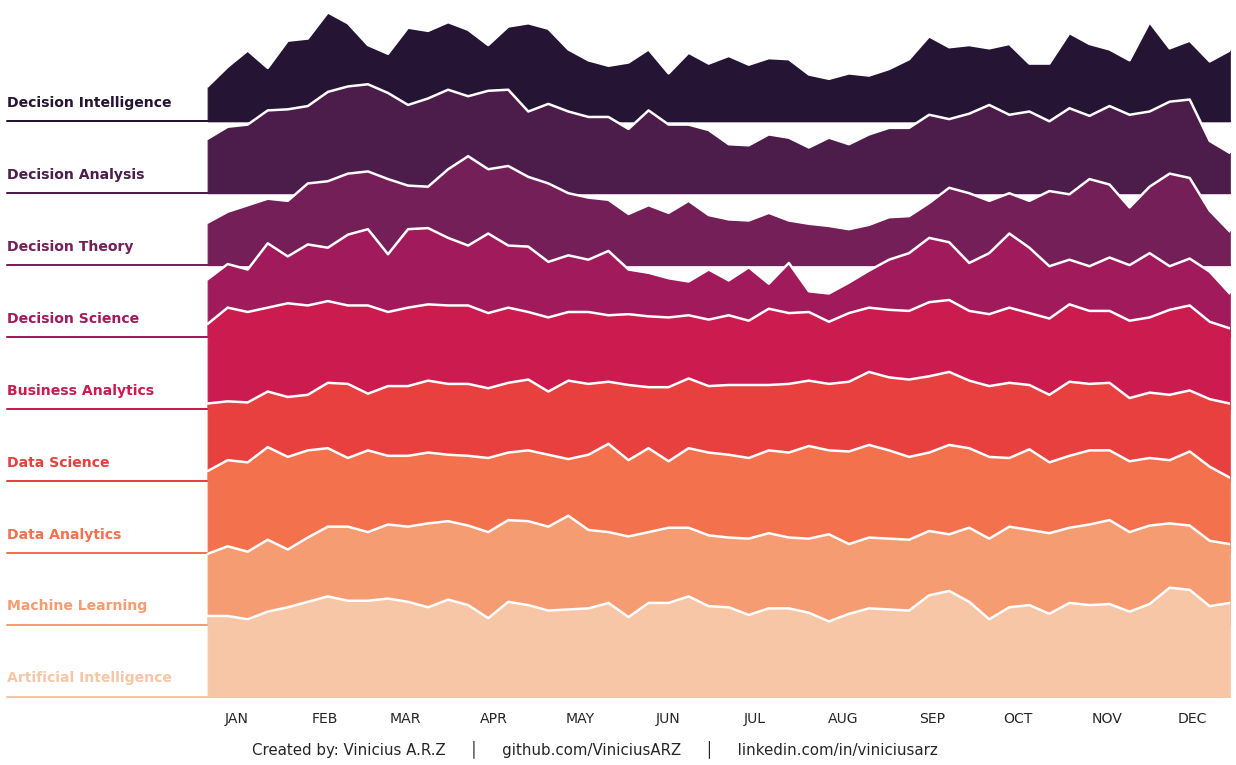

In [107]:
df = get_interest_over_time(['Decision Intelligence','Decision Analysis','Decision Theory',
                             'Decision Science','Business Analytics','Data Science','Data Analytics',
                             'Machine Learning','Artificial Intelligence'],
                            '2022-01-01 2022-12-31',1,0,"",False)

draw_ridgeplot(df,aspect=15,height=1.2,palette='rocket',title='Decision Intelligence Related Terms 2022')